In [366]:
from virtual_swap.deprecated.vswap_pass import VirtualSwap
from qiskit import QuantumCircuit

# from qiskit.test import QiskitTestCase
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    Unroller,
    TrivialLayout,
    DenseLayout,
    ApplyLayout,
    SabreLayout,
    CountOpsLongestPath,
    Collect1qRuns,
    Collect2qBlocks,
    ConsolidateBlocks,
    SabreSwap,
)
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
import numpy as np

from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
)
from virtual_swap.sqiswap_equiv import sel

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.converters import dag_to_circuit

In [367]:
# this code is buggy, see https://github.com/Qiskit/qiskit-terra/pull/9375
# I can't use this version bc qiskit version missing DAGCircuit functionality
from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition

In [368]:
from virtual_swap.vswap_verbose import VirtualSwap as VirtualSwapVerbose
from virtual_swap.vswap_simple import VirtualSwap as VirtualSwapSimple
from virtual_swap.vswap_pass import VSwapPass as VirtualSwap

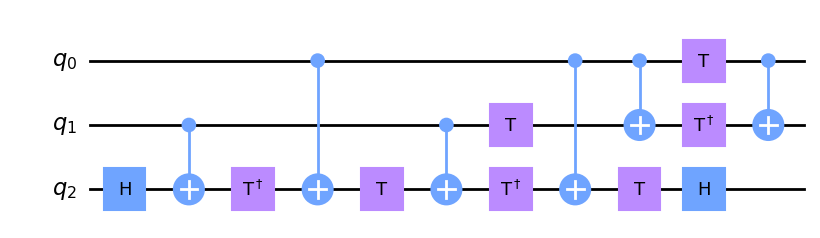

In [369]:
# # build a toffoli
# qc = QuantumCircuit(8)
# qc.ccx(0, 1, 2)
# qc.cx(1, 7)
# qc.ccx(3, 4, 5)
# qc.ccx(2, 5, 6)
# # build a 2x2 square coupling map
# coupling = CouplingMap.from_line(8)

# # build a toffoli
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
linear = CouplingMap.from_line(4)
a2a = CouplingMap.from_full(3)
coupling = linear
qc.decompose().draw("mpl")

In [370]:
# # generate a QFT circuit
# from qiskit.circuit.library import QFT
# qc = QuantumCircuit(16)
# qc.cx(0,1)
# coupling = CouplingMap.from_grid(4,4)

In [430]:
# generate network of random cnots
n, M = 3, 6
N = n**2
qc = QuantumCircuit(N)

for _ in range(M):
    qc.cx(*np.random.choice(N, 2, replace=False))

# coupling = CouplingMap.from_grid(n,n)
coupling = CouplingMap.from_line(N + 1)
# a2a = CouplingMap.from_full(N)
qc.decompose().draw("mpl")

Total: 12
Depth: 4


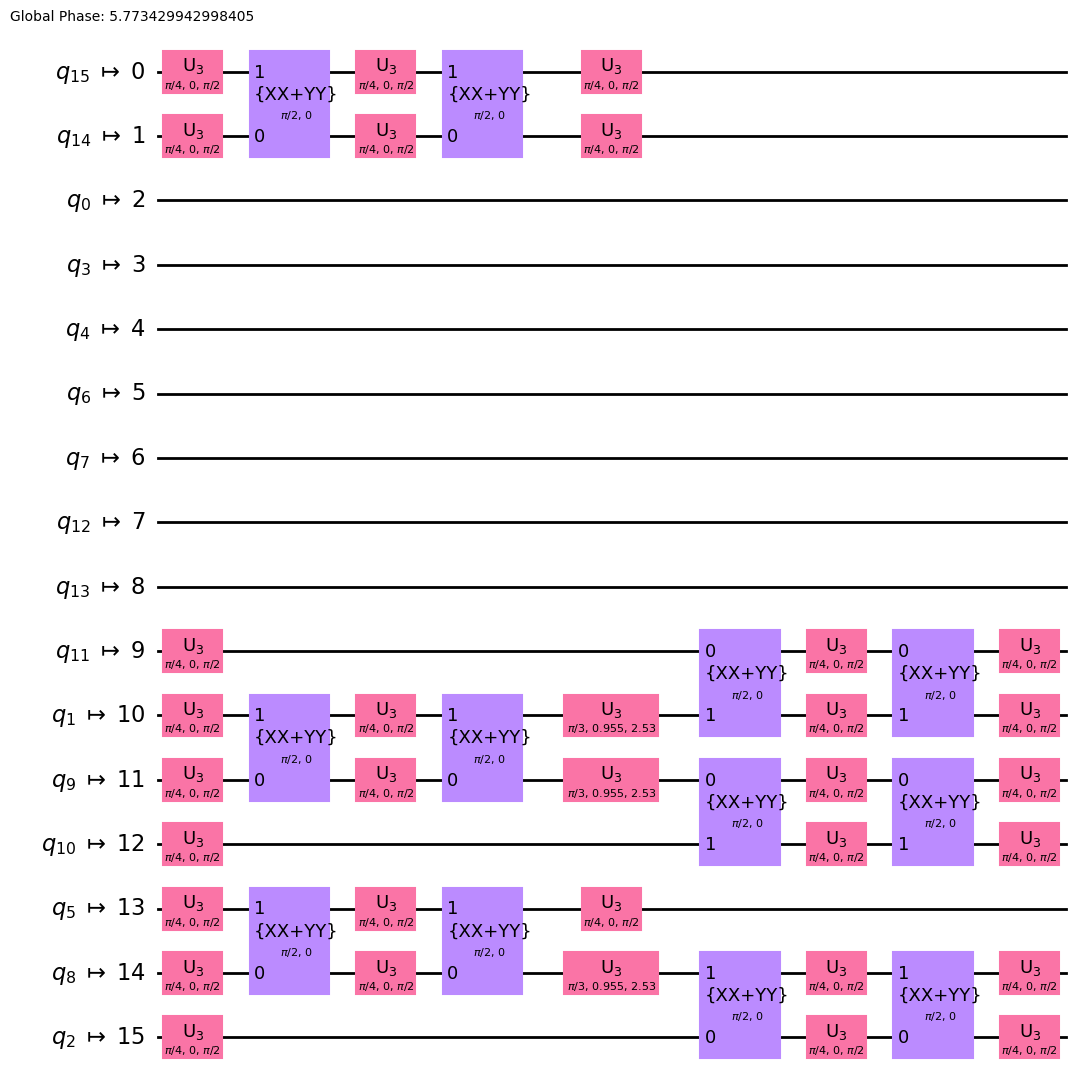

In [428]:
from qiskit import transpile

# qc2 = transpile(
#     qc, coupling_map=coupling, basis_gates=["cx", "u3"], optimization_level=3
# )
from virtual_swap.sqiswap_equiv import sel

qc2 = transpile(
    qc, coupling_map=coupling, basis_gates=["xx_plus_yy", "u3"], optimization_level=3
)

# t0_pm = PassManager([RootiSwapWeylDecomposition()])
# qc3 = t0_pm.run(qc2)

print(f"Total: {qc2.count_ops().get('xx_plus_yy', 0)}")
print(
    f"Depth: {qc2.depth(filter_function=lambda x: x.operation.name not in ['u3', 'u'])}"
)

qc2.draw(output="mpl")

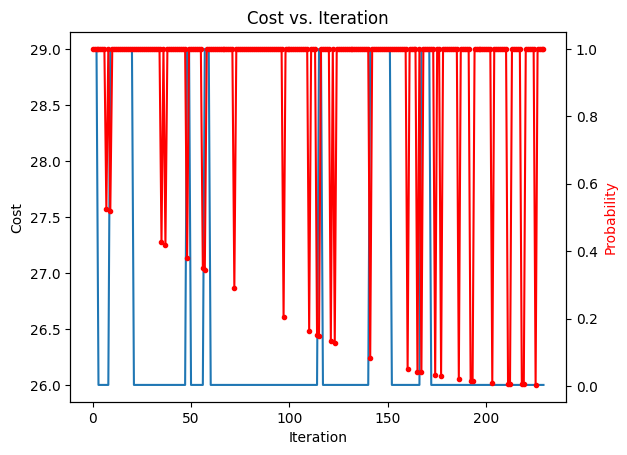

Total: 66
Depth: 31
global phase: π
                                                                    »
  q_0 -> 0 ─────────────────────────────────────────────────────────»
                                                                    »
  q_1 -> 1 ────────X───────────────X────────────────────────────────»
                   │               │                                »
  q_2 -> 2 ────────X─────────X─────X───────────X────────────────────»
                             │                 │                    »
  q_3 -> 3 ──────────────────X─────X───────────X────────────■───────»
                                   │                      ┌─┴─┐     »
  q_4 -> 4 ────────────────────────X────────────────────X─┤ X ├─────»
           ┌───────────────┐                            │ └───┘     »
  q_5 -> 5 ┤ U(π/2,-π/2,π) ├─X─────────────────X────────X───X───────»
           └───────────────┘ │ ┌────────┐      │            │  ┌───┐»
  q_6 -> 6 ──────────────────X─┤1       ├──────X──────

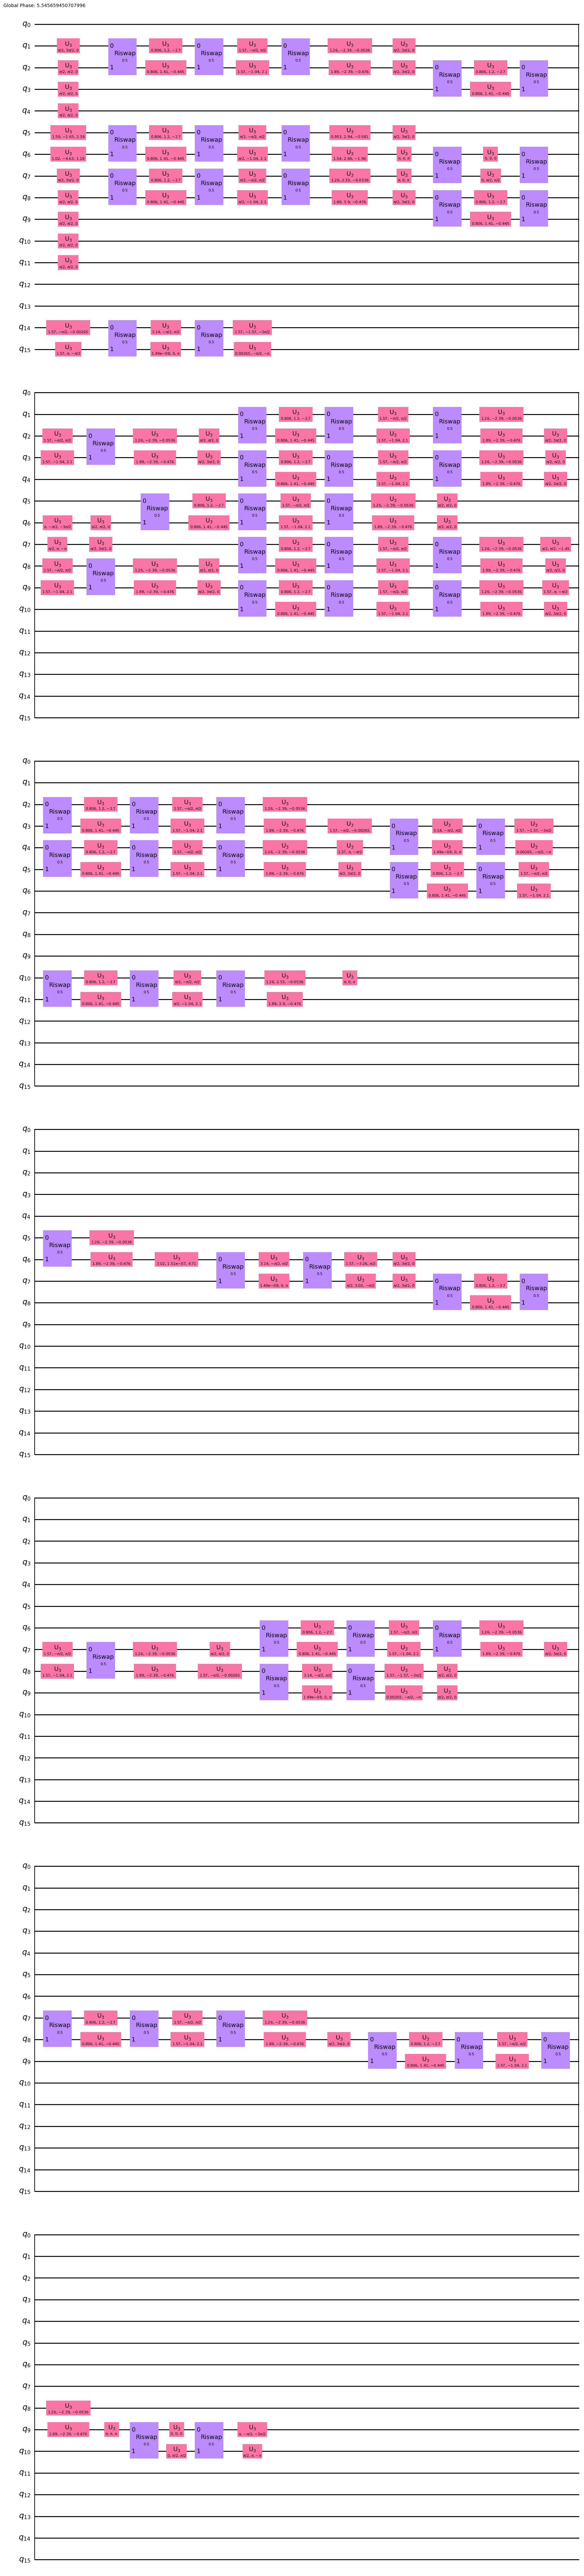

In [429]:
# run the pass
pm = PassManager()
pm.append([TrivialLayout(coupling)])
pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
pm.append(VirtualSwap(coupling, visualize=True))
pm.append(SabreSwap(coupling))
pm.append([OptimizeSwapBeforeMeasure()])

pm2 = PassManager()
pm2.append(
    [Collect1qRuns(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)]
)
pm2.append([RootiSwapWeylDecomposition()])
new_circ = pm.run(qc)
new_circ_decomp = pm2.run(new_circ)

print(f"Total: {new_circ_decomp.count_ops().get('riswap', 0)}")
print(
    f"Depth: {new_circ_decomp.depth(filter_function=lambda x: x.operation.name not in ['u3', 'u'])}"
)
print(new_circ.draw())
new_circ_decomp.draw("mpl")

In [390]:
# qc == qc2 == new_circ_decomp?
# I check with Operator.equiv but false
# idk why

False

In [409]:
# XXPlusYYGate(np.pi/2) equiv to riswap(0.5)?
from slam.utils.gates.custom_gates import RiSwapGate
from qiskit.quantum_info import Operator
from qiskit.circuit.library import XXPlusYYGate

Operator(XXPlusYYGate(-np.pi / 2)).equiv(RiSwapGate(0.5))

True

In [401]:
from qiskit.circuit.library import XXPlusYYGate, SwapGate, CXGate
from qiskit.quantum_info import Operator

cx_decomp = QuantumCircuit(2)
cx_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
cx_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
cx_decomp.append(XXPlusYYGate(-np.pi / 2, 0), [0, 1])
cx_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
cx_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
cx_decomp.append(XXPlusYYGate(-np.pi / 2), [0, 1])
cx_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
cx_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
# sel.add_equivalence(CXGate(), cx_decomp)
assert Operator(CXGate()).equiv(Operator(cx_decomp))

swap_decomp = QuantumCircuit(2)
swap_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
swap_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
swap_decomp.append(XXPlusYYGate(-np.pi / 2, 0), [0, 1])
swap_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
swap_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
swap_decomp.append(XXPlusYYGate(-np.pi / 2), [0, 1])
swap_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
swap_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
swap_decomp.append(XXPlusYYGate(-np.pi / 2), [0, 1])
swap_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
swap_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
# sel.add_equivalence(SwapGate(), swap_decomp)
assert Operator(SwapGate()).equiv(Operator(swap_decomp))

AssertionError: 

In [ ]:
# from transpile_benchy.main import Benchmark
# from qiskit.transpiler.passes import RemoveBarriers, RemoveFinalMeasurements
# from qiskit.transpiler.passes.layout import DenseLayout

# coupling = CouplingMap.from_line(8)

# # define some function that takes a circuit and returns a transpiled circuit
# def t0(qc):
#     cc = transpile(
#         qc, coupling_map=coupling, basis_gates=["cx", "u3"], optimization_level=3
#     )
#     t0_pm = PassManager([RootiSwapWeylDecomposition()])
#     return t0_pm.run(cc)


# def t1(qc):
#     pm = PassManager()
#     pm.append([TrivialLayout(coupling)])
#     pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
#     pm.append(VirtualSwap(coupling, visualize=True))
#     pm.append(SabreSwap(coupling))
#     pm.append([OptimizeSwapBeforeMeasure()])
#     pm.append(
#         [Collect1qRuns(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)]
#     )
#     pm.append([RootiSwapWeylDecomposition()])
#     return pm.run(qc)


# b = Benchmark(t0, t1, size="small", prepath="../../../../transpile_benchy")
# b.run()

# # plot and save as svg
# b.plot(save=True)

# print(b.depth_list)